In [11]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.standard_gates import CSwapGate
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers import fake_provider
from qiskit.visualization import plot_histogram
from qiskit import transpile

# Import components for tomography
from qiskit_aer import AerSimulator
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix
import qiskit.quantum_info as qi

# W circuit state preparation

We develop and contrast two quantum circuits dedicated to the preparation of a generalized W state across n qubits.

The first circuit employs an iterative technique which exclusively necessitates next-neighbour connectivity, making it particularly suitable for execution on Qiskit quantum devices.

For comparison we also implement a W state preparation protocol using a recursive algorithm and ancilla qubits. From a theoretical standpoint, both algorithms represent the current state-of-the-art, necessitating a depth of O(n).

However, we demonstrate that our proposed algorithm is substantially more optimized for deployment on Qiskit quantum machines. Not only does it showcase superior resource efficiency, but it also achieves better performance in terms of circuit depth. Consequently, it offers an improved method for W state preparation in the context of the practical constraints of current quantum hardware.

We evaluate the circuits based on the number of qubits they encode for a given device, the depth and the number of CX gates it uses, as they the most erroneous gates. 

We assess the performance of these circuits based on three key parameters. These include the number of qubits encoded for a specific device, the circuit depth, and the number of CX gates. The latter is particularly significant, as CX gates are known to be the most error-prone.

In [30]:
# Choose a backend that is based on a {CX, ID, RZ, SX, X} gate set 
backend = fake_provider.FakeGuadalupe()
N_of_device=backend.configuration().n_qubits
print("No of qubits",N_of_device)

No of qubits 16


### Circuit I: Iterative approach, relying on text to nearest neighbors connectivity. All operations have directly been converted to use the gate set {CX, ID, RZ, SX, X}, that most Qiskit quantum devices operate on.

In [31]:
def get_angle(q):
    return np.arcsin( np.sqrt(1/(1+q)) )

def U(qc, r, angle):
    qc.sx(r)
    qc.rz(angle,r)
    qc.x(r)
    
def U_t(qc, r, angle):
    qc.rz(angle,r)
    qc.sx(r)
    
    
def WState_2Conec(qc, N, path = None):
    if path is None:
        path = range(N)
    angle = get_angle(N-1)
    qc.sx(0)
    qc.rz(2*angle,0)
    qc.sx(0)
    
    for i in range(N-2):
        angle = get_angle(N-i-2)
        U(qc,path[i+1],angle)
        qc.cx(path[i],path[i+1])
        U_t(qc,path[i+1],angle)
    
    for i in range(N-1):
        qc.cx(path[N-2-i], path[N-1-i])
    qc.x(path[0])




In [32]:
# Functions to find longest connected path form a device
def clean(graph):
    output = []
    for pair in graph:
        if pair in output or [pair[1],pair[0]] in output:
            continue
        else:
            output.append(pair)
    return output

def find_longest_path(graph, start, visited=None):
    if visited is None:
        visited = []

    visited.append(start)
    paths = []
    if len(visited)-1 != len(graph):
        for neighbor in graph[start]:
            if neighbor not in visited:
                paths.append(find_longest_path(graph, neighbor, visited.copy()))

    return max(paths, key=len, default=visited)

In [36]:
coupling_map = backend.configuration().coupling_map
length = backend.configuration().n_qubits
longest_path = find_longest_path(clean(coupling_map), clean(coupling_map)[0][0])

N = len(longest_path)
qc= QuantumCircuit(N_of_device)
WState_2Conec(qc, N,longest_path)


qc_transpiled = transpile(qc, backend)
print("########################################################")
print(f'N = {N} encoded qubits W_state prpared on', "\n")
print("circuit depth", qc_transpiled.depth(), "\n")
print("Operation count",dict(qc_transpiled.count_ops()))
print("########################################################")

########################################################
N = 14 encoded qubits W_state prpared on 

circuit depth 57 

Operation count {'cx': 31, 'sx': 26, 'rz': 25, 'x': 13}
########################################################


{'0000110000100000': 1, '1000000001110000': 1, '1000001000000000': 1, '1000000010001000': 1, '0010000001010000': 1, '0010000000000111': 1, '0000100100110000': 1, '0000010000010100': 1, '0100000010000000': 1, '0000000100110100': 1, '0000010000000010': 1, '1000100000000011': 1, '0000000000000101': 1, '1110000000000000': 1, '0000010010000000': 1, '1000000000110000': 1, '0000000000100100': 1, '1000010000000000': 2, '1001100000000110': 1, '1000000000000011': 1, '0000000010000000': 49, '0000001000010000': 1, '0000100000100000': 1, '1000100000000000': 2, '0100000000000011': 2, '0000000000101000': 1, '0010000100000111': 1, '0000000011000010': 1, '0100000011000000': 1, '1100000010000000': 1, '0100000000000010': 1, '0010110000000000': 1, '0000010000100000': 2, '0010100000000100': 1, '0010000000010100': 1, '0000110100000000': 2, '0000110000000001': 1, '0000010001000000': 1, '0010000001000000': 2, '0010000000000010': 2, '0000000010010100': 1, '0001000000010000': 2, '0101100000000000': 1, '00000000

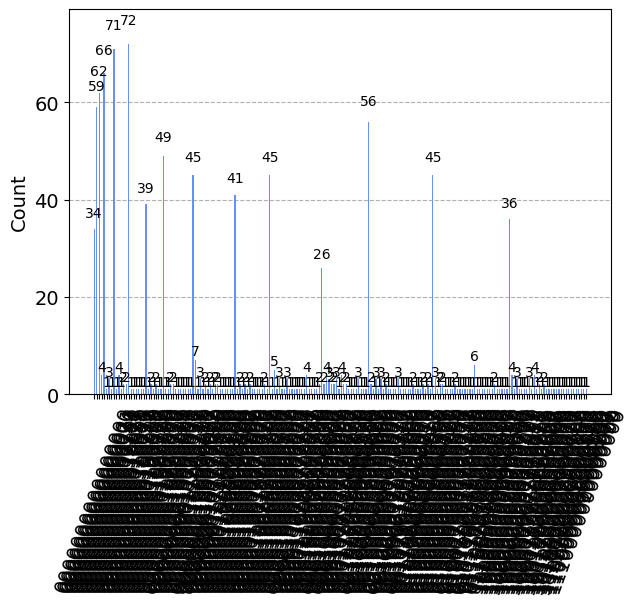

In [37]:
qc.measure_all()
job = execute(qc, backend)
result = job.result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)
# qc_transpiled.depth()

### Circuit II: Based on recursive algorithm. Uses ancilla qubits that require large connectivity. Relies on CSWAP gate, that is not part of the standard set the device is operation on and is via default operations converted.

In [38]:
#Pre: N is a power of 2:  N= 2**M
#Post: Returns a W state on the first N qubits of the circuit qc
def WState_PowerOfTwo_Reference(qc, N):
    if N == 1:
        # base of recursion: |1⟩
        qc.x(0)
    else:
        K = N // 2
        # create W state on the first K qubits
        WState_PowerOfTwo_Reference(qc, K)

        # the next K qubits are in |0...0⟩ state
        # allocate ancilla in |+⟩ state
        anc = QuantumRegister(1, f'anc{N}')
        qc.add_register(anc)
        qc.h(anc)

        for i in range(K):
            qc.append(CSwapGate(), [anc[0], i, i + K])

        for i in range(K, N):
            qc.cx(i, anc[0])

In [39]:
def find_largest_m(N):
    #returns number of ancilla qubits the recursive algorithm requires
    m = N - 1
    while m > 0:
        if 2**m + m < N:       
            return m
        m -= 1
    return None

M = find_largest_m(N)
qc_rec= QuantumCircuit(2**M)
WState_PowerOfTwo_Reference(qc_rec, 2**M)

qc_rec_transpiled= transpile(qc_rec, backend)
print(f'N = {2**M} no of qubits W_state prpared on', "\n")
print("circuit depth", qc_rec_transpiled.depth(), "\n")
print("Operation count",dict(qc_rec_transpiled.count_ops()))


N = 8 no of qubits W_state prpared on 

circuit depth 148 

Operation count {'cx': 149, 'rz': 76, 'sx': 17, 'x': 1}


{'11001010001': 1, '10000011101': 1, '10010010010': 1, '00001011010': 1, '01000010101': 1, '11001001100': 1, '01001010000': 1, '01111010010': 1, '01100100011': 1, '00010000001': 2, '11101000010': 1, '11000011100': 2, '10000100100': 1, '11001000100': 1, '10000100010': 1, '00010101000': 1, '01001010001': 1, '01001000000': 2, '10000110110': 1, '01001100001': 1, '00001010001': 1, '01000010001': 1, '10000101110': 1, '00000010100': 1, '01001011010': 1, '11010010000': 1, '10000000100': 3, '10001010100': 2, '10000101000': 2, '01000010100': 1, '10011000000': 3, '10001001001': 1, '00000001101': 2, '00000010011': 1, '00000001011': 1, '11100011010': 1, '01000000011': 1, '00100001010': 1, '10000001001': 2, '10011011001': 1, '10001101000': 1, '00001011101': 1, '00010100001': 1, '00011010000': 1, '10110011000': 1, '11100100001': 1, '00100100001': 1, '01001001101': 1, '01101000000': 1, '11010010001': 1, '10101000100': 1, '11000110000': 1, '10001001010': 1, '11110001001': 1, '01000000000': 14, '0000001

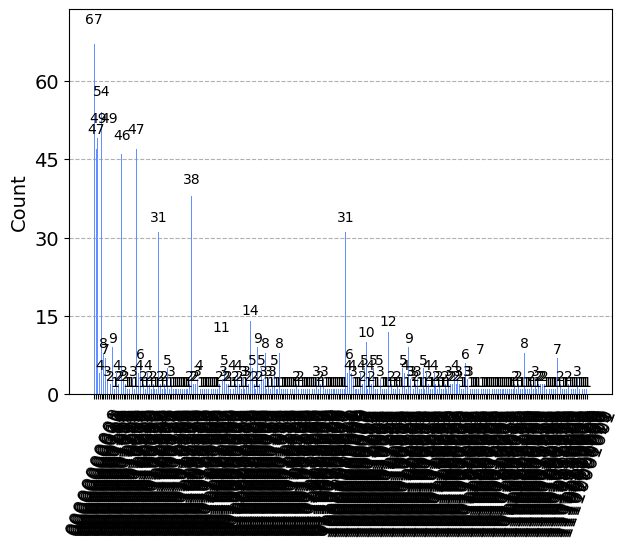

In [40]:
qc_rec.measure_all()
job = execute(qc_rec, backend)
result = job.result()
counts = result.get_counts(qc_rec)
print(counts)
plot_histogram(counts)

## Discussion

Taking the Guadalupe device as an example, our proposed circuit demonstrates considerable efficiency. It encodes 14 out of 16 qubits into a W state with a depth of 57 and uses only 31 CX gates.

In contrast, the recursive algorithm, which relies heavily on ancilla qubits with extensive connectivity, falls short on these parameters. It can only encode 8 out of 16 qubits, and it has a depth of 148, using a substantial 149 CX gates. This large use of CX gates by the recursive algorithm is particularly noticeable when compared to the minimal usage in our proposed solution.

In conclusion, our proposed iterative circuit significantly outperforms the recursive algorithm on all evaluated parameters. It provides a more efficient solution for the preparation of W states, demonstrating increased qubit encoding, reduced circuit depth, and minimal usage of error-prone CX gates. This result underscores the potential of our circuit for practical implementations in quantum computing using the Qiskit platform.

# Appendix

## Fidelity

To assess fidelity, we employ a benchmark algorithm run on a hypothetical, non-realistic circuit geometry that produces an exact W state. This is contrasted with the density matrix derived from transpiling our quantum circuit using a simulated (fake) backend. We further apply the StateTomography function and execute a simulation using the same simulated backend. The fidelity is measured with on device with 5 qubits and results are encouraging.

In [13]:
backend = fake_provider.FakeManila()


coupling_map = backend.configuration().coupling_map
length = backend.configuration().n_qubits
longest_path = find_longest_path(clean(coupling_map), clean(coupling_map)[0][0])
N = len(longest_path)
qc= QuantumCircuit(N)
WState_2Conec(qc, N)

qc_transpiled = transpile(qc, backend)


# evolve the statevector
sv= Statevector.from_label('0'*N)
sv_ev=sv.evolve(qc)

theo_dm = DensityMatrix(sv_ev)

# QST Experiment
qstexp1 = StateTomography(qc_transpiled)
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

den_mat1 = qstdata1.analysis_results("state").value

fid_result = qi.state_fidelity(den_mat1,theo_dm)

print(fid_result)

Adding a job from a backend (aer_simulator) that is different than the current backend (fake_manila). The new backend will be used, but service is not changed if one already exists.


0.6948823395340641


## Device independent circuit and resulting W state

For clarity consider the general circuit for a small number of qubits. Form an intuitive perspective the algorithm splits in every iteration a pure 0 state into a small component containing an excitation 
at i and larger 0 component. The larger 0 component is split in the next iteration further apart until a W state is generated. 

In [124]:
n =4
qc = QuantumCircuit(n)
WState_2Conec(qc, n)
qc.draw()


┌────┐  ┌─────────┐  ┌────┐                                          »
q_0: ┤ √X ├──┤ Rz(π/3) ├──┤ √X ├──■───────────────────────────────────────»
     ├────┤┌─┴─────────┴─┐├───┬┘┌─┴─┐┌─────────────┐┌────┐                »
q_1: ┤ √X ├┤ Rz(0.61548) ├┤ X ├─┤ X ├┤ Rz(0.61548) ├┤ √X ├──■─────────────»
     ├────┤└─┬─────────┬─┘├───┤ └───┘└─────────────┘└────┘┌─┴─┐┌─────────┐»
q_2: ┤ √X ├──┤ Rz(π/4) ├──┤ X ├───────────────────────────┤ X ├┤ Rz(π/4) ├»
     └────┘  └─────────┘  └───┘                           └───┘└─────────┘»
q_3: ─────────────────────────────────────────────────────────────────────»
                                                                          »
«                          ┌───┐
«q_0: ──────────────────■──┤ X ├
«                     ┌─┴─┐└───┘
«q_1: ─────────────■──┤ X ├─────
«     ┌────┐     ┌─┴─┐└───┘     
«q_2: ┤ √X ├──■──┤ X ├──────────
«     └────┘┌─┴─┐└───┘          
«q_3: ──────┤ X ├───────────────
«           └───┘

In [122]:
sv= Statevector.from_label('0'*n)
sv_ev=sv.evolve(qc)
sv_ev.draw('latex')

<IPython.core.display.Latex object>